In [2]:
import os
import sys
src_path = sys.path[0].replace("figures", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("figures", "output")

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from matplotlib import pyplot as plt

from grid_manager import MPC_op
from data_loader import UCSD_dataloader
from battery_model import Battery_base
from optimizer import Battery_optimizer
from predictor import *
from utils.plot_utils import *

customize_plt()

exp_suffix = "Mar2023"
exp_folder = os.path.join(out_path, "experiments", exp_suffix)
assert os.path.exists(exp_folder)

In [3]:
log_fn = "LOG-EV_battery_rep.xlsx"
log_df = pd.read_excel(os.path.join(exp_folder, log_fn), index_col=0)

In [15]:
def get_identifier(df, cols, col_name=True):
    def lambda_id(x):
        s = ""
        for c in cols:
            if col_name:
                s += f"_{c}-{x[c]}"
            else:
                s += f"_{x[c]}"
        return s[1:]
    return df.apply(lambda_id, axis=1)

In [17]:
idx = get_identifier(log_df, ["ev_charge_rule", "ev_to_bld"], col_name=False)
log_df.index = idx

In [39]:
ev_ratios = np.arange(0, 1.1, 0.2)
rules = ["flex", "V2G", "asap", "unif"]

res = {rule: {} for rule in rules}

for rule in rules:
    idx = ["{}_{:.1f}".format(rule, r) for r in ev_ratios]
    res[rule]["eq_bat_capacity"] =  log_df.loc[idx, "eq_bat_capacity"].values
    res[rule]["eq_rate"] =  log_df.loc[idx, "eq_rate"].values

In [60]:
rule_names = {
    "flex": "FLEX",
    "V2G": "V2G",
    "asap": "ASAP",
    "unif": "UNIF"
}

rule_colors = {
    "flex": "royalblue",
    "V2G": "mediumseagreen",
    "asap": "tomato",
    "unif": "goldenrod"
}

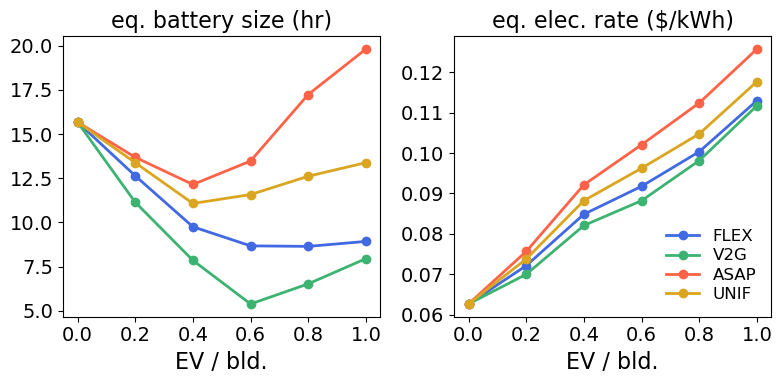

In [62]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))

for i in range(2):
    ax = axs[i]
    key = "eq_bat_capacity" if i == 0 else "eq_rate"
    ylabel = "eq. battery size (hr)" if i == 0 else "eq. elec. rate ($/kWh)"

    for rule in rules:
        ax.plot(ev_ratios, res[rule][key], "o-", c=rule_colors[rule], label=rule_names[rule])
    
    if i == 1:
        ax.legend(loc="lower right", handlelength=2)
        # ax.yaxis.set_label_position("right")
        # ax.yaxis.tick_right()

    ax.set_xticks(ev_ratios)
    ax.set_xlabel("EV / bld.")

    ax.set_title(ylabel)

plt.tight_layout()
# plt.savefig("214-fig5-EV_bat.png", dpi=300, facecolor="w", bbox_inches="tight")
